In this post, we'll produce an animation of the k-means algorithm. The k-means algorithm is a very useful clustering tool. It allows you to cluster your data into a given number of categories.

The algorithm, as described in [Andrew Ng's Machine Learning class over at Coursera](https://www.coursera.org/learn/machine-learning/lecture/93VPG/k-means-algorithm) works as follows:

- initialize $k$ cluster centroids
- repeat the following:
    - for each point, compute which centroid is nearest to it
    - for each centroid, move its location to the mean location of the points assigned to it

A word of caution before going on: in this post, we will write pure numpy based functions, based on the numpy array object. This has advantages but also disadvantages. In particular:

- the code becomes efficient and fast, due to the fact that numpy supports vector operations that are coded in C
- at the expense of being readable, which is usually what Python code is

To follow along, a working knowledge of numpy is therefore necessary.

To implement the algorithm, we will start by defining a dataset to work with. We choose a dataset containing three clusters, with a little bit of variance around each cluster center. We construct the point cloud by stacking shifted random numbers:

In [101]:
# necessary imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

In [102]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

We can plot the dataset as well as the cluster centers:

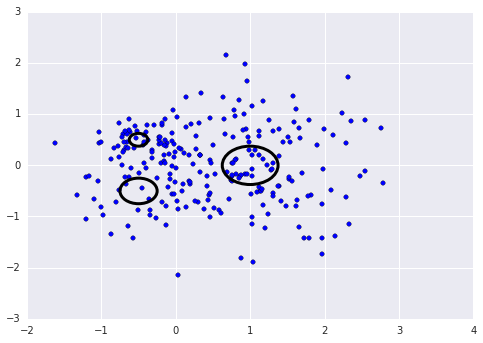

In [103]:
plt.scatter(points[:, 0], points[:, 1])
ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))

We now write a function that initializes k centroids by randomly selecting them from the data points.

In [104]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

Let's try the function:

In [105]:
initialize_centroids(points, 3)

array([[-0.48840901, -0.14088659],
       [-0.53984176,  0.53868892],
       [ 0.98947381,  0.30255966]])

Let's represent the results using a plot:

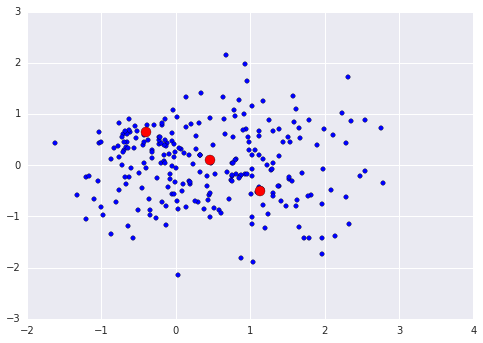

In [106]:
plt.scatter(points[:, 0], points[:, 1])
centroids = initialize_centroids(points, 3)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

Now let's define a function that returns the closest centroid for each point. We will use numpy broadcasting to do this. If this code looks overly complicated, don't worry, we'll try to explain why it works in the next section.

In [107]:
def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

We can test the code like so:

In [108]:
c = initialize_centroids(points, 3)
closest_centroid(points, c)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0,
       0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1], dtype=int64)

So why does the previous function work? It makes use of what I would call some advanced numpy broadcasting tricks. 

To investigate this broadcasting into more detail, let's look at some intermediate steps in the computing process. First, our variable `c` denotes our centroids that we want to work with. Let's look at their coordinates:

In [109]:
c

array([[-0.04883724,  0.6316724 ],
       [ 0.27231992,  0.32268518],
       [-0.76809563,  0.82267701]])

One of the interesting things with numpy is that we can extend an array by a new dimension using the `np.newaxis` command like this:

In [110]:
c_extended = c[: , np.newaxis, :]
c_extended

array([[[-0.04883724,  0.6316724 ]],

       [[ 0.27231992,  0.32268518]],

       [[-0.76809563,  0.82267701]]])

Our array, which had a shape of 3x2 becomes an array of the following shape:

In [111]:
c_extended.shape

(3L, 1L, 2L)

We've just added a dimension in the middle of the array. This allows us to substract this array from an existing point `p`, due to the fact that numpy applies broadcasting rules to array of non-matching sizes which allow for efficient operations (this is described in detail in the broadcasting section of the following document: [http://nbviewer.ipython.org/url/www.astro.washington.edu/users/vanderplas/Astr599_2014/notebooks/11_EfficientNumpy.ipynb](http://nbviewer.ipython.org/url/www.astro.washington.edu/users/vanderplas/Astr599_2014/notebooks/11_EfficientNumpy.ipynb)).

In particular, the rule used here for non-matching dimensions is:

> If the two arrays differ in their number of dimensions, the shape of the array with fewer dimensions is padded with ones on its leading (left) side.

In [112]:
p = points[0]
p

array([ 1.13251313, -0.49784654])

In [113]:
c_extended - p

array([[[-1.18135037,  1.12951893]],

       [[-0.86019321,  0.82053172]],

       [[-1.90060876,  1.32052355]]])

In [114]:
(c_extended - p).shape

(3L, 1L, 2L)

The broadcasting allows us to keep the first dimension as the point dimension, which allows us to generalize the trick for more than one point, as demonstrated by the next line:

In [115]:
points[:4] - c_extended

array([[[  1.18135037e+00,  -1.12951893e+00],
        [  3.19833710e-01,  -5.72897144e-02],
        [  1.66808263e+00,   4.60938179e-01],
        [  1.45933022e+00,  -1.33264298e+00]],

       [[  8.60193206e-01,  -8.20531719e-01],
        [ -1.32345648e-03,   2.51697498e-01],
        [  1.34692546e+00,   7.69925391e-01],
        [  1.13817306e+00,  -1.02365577e+00]],

       [[  1.90060876e+00,  -1.32052355e+00],
        [  1.03909210e+00,  -2.48294333e-01],
        [  2.38734102e+00,   2.69933560e-01],
        [  2.17858861e+00,  -1.52364760e+00]]])

This then allows us to apply square root, square and sum operations that efficiently reduce the number of dimensions of the matrix:

In [116]:
np.sqrt(((points[:4] - c_extended)**2).sum(axis=2))

array([[ 1.63444233,  0.32492417,  1.73059633,  1.97625455],
       [ 1.18878284,  0.25170098,  1.55144878,  1.53078707],
       [ 2.31432412,  1.06834567,  2.40255307,  2.6585241 ]])

Finally, we can obtain the index of the closest centroid using the `np.argmin` function:

In [117]:
np.argmin(np.sqrt(((points[:4] - c_extended)**2).sum(axis=2)), axis=0)

array([1, 1, 1, 1], dtype=int64)

The last step in the algorithm is to move the centroids to the mean location associated with it:

In [118]:
def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

In [119]:
move_centroids(points, closest_centroid(points, c), c)

array([[-0.06971844,  0.66614582],
       [ 0.85831935, -0.18948577],
       [-0.82669027,  0.23483006]])

We can visualize these first two steps in the following way:

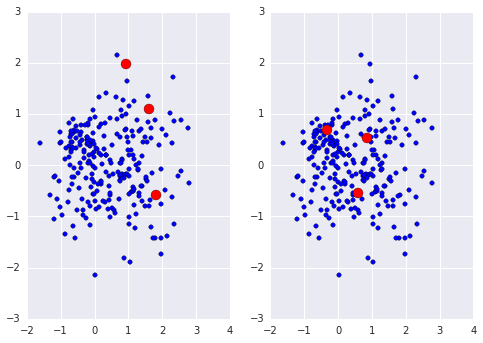

In [120]:
plt.subplot(121)
plt.scatter(points[:, 0], points[:, 1])
centroids = initialize_centroids(points, 3)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

plt.subplot(122)
plt.scatter(points[:, 0], points[:, 1])
closest = closest_centroid(points, centroids)
centroids = move_centroids(points, closest, centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

We can animate this type of plot using a module called JSAnimation:


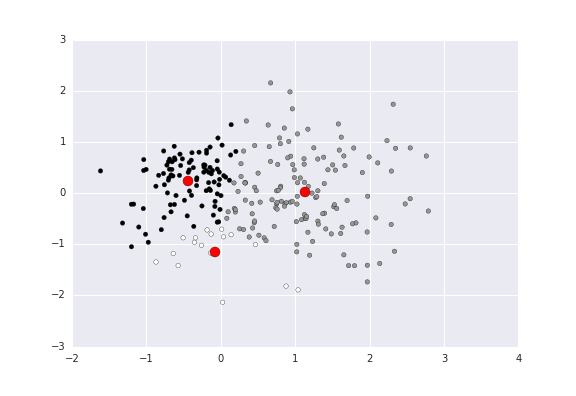
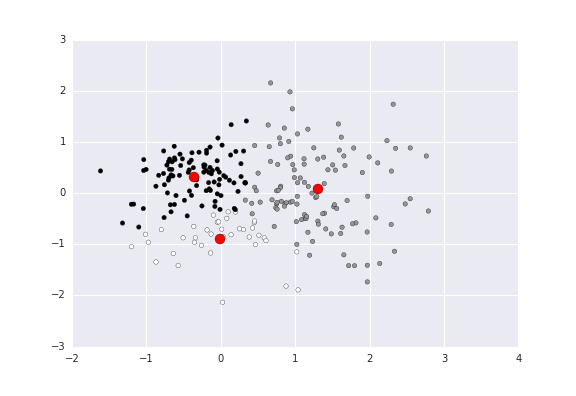
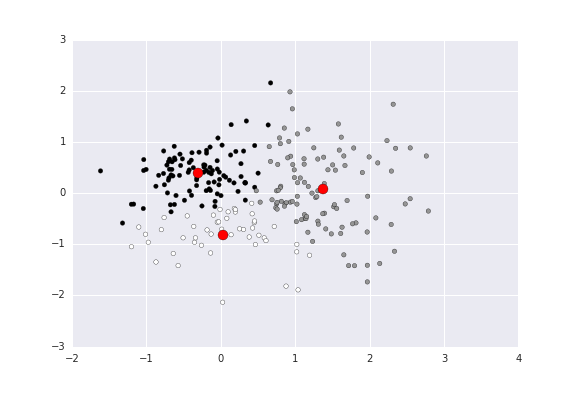
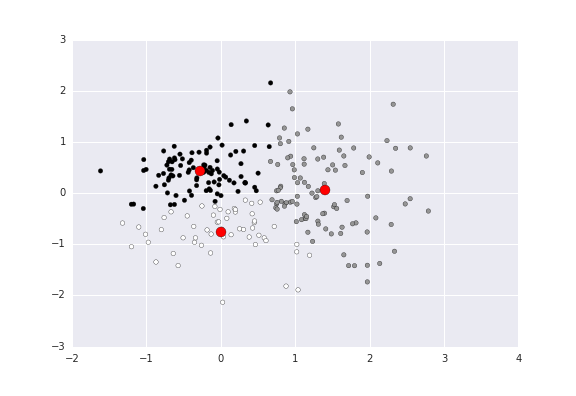
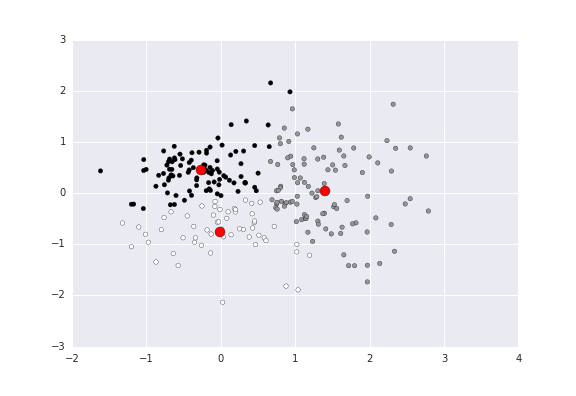
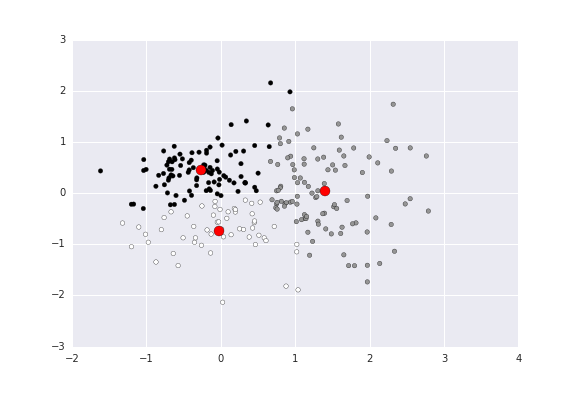
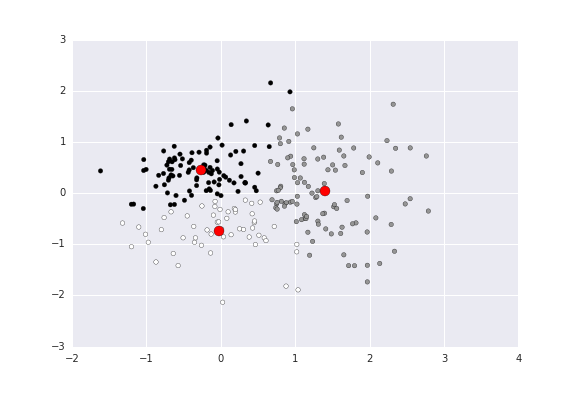
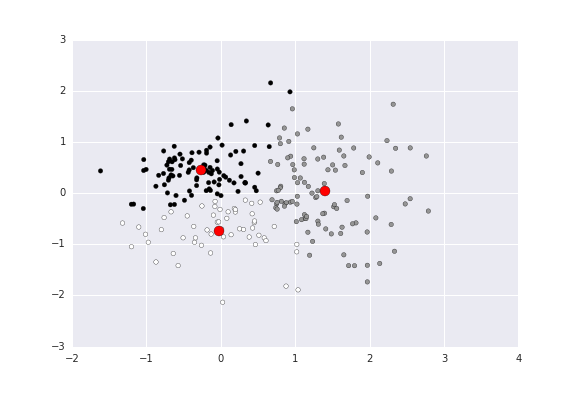
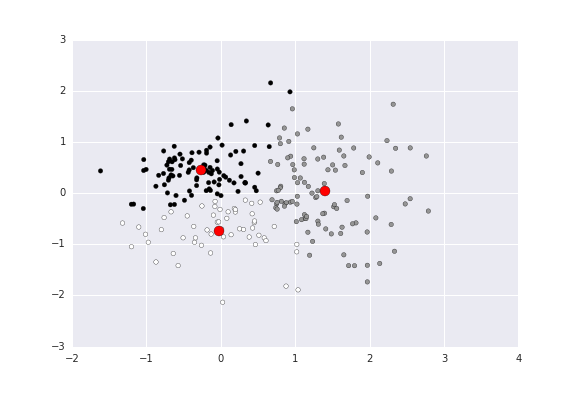
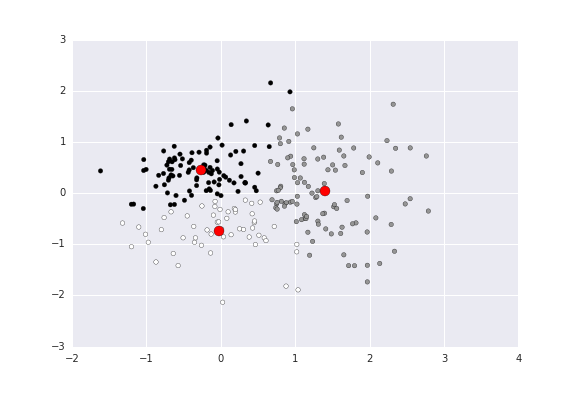

In [121]:
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-4, 4))
centroids = initialize_centroids(points, 3)

def init():
    return

def animate(i):
    global centroids
    closest = closest_centroid(points, centroids)
    centroids = move_centroids(points, closest, centroids)
    ax.cla()
    ax.scatter(points[:, 0], points[:, 1], c=closest)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)
    return 

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=10, interval=200, blit=True)

The previous animation shows how the points in the dataset are changing their assigned centroid and how the centroid itself moves.

We can also try running the same type of animation using more clusters than intended in the original data:


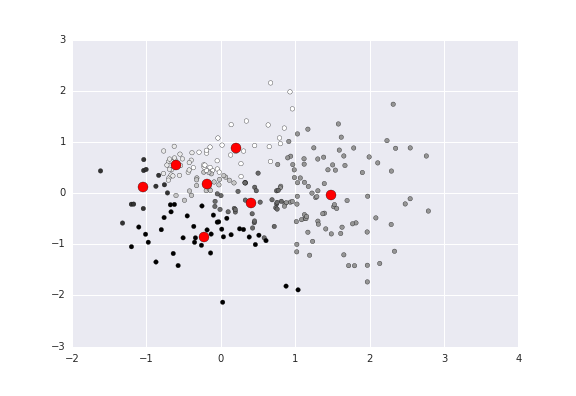
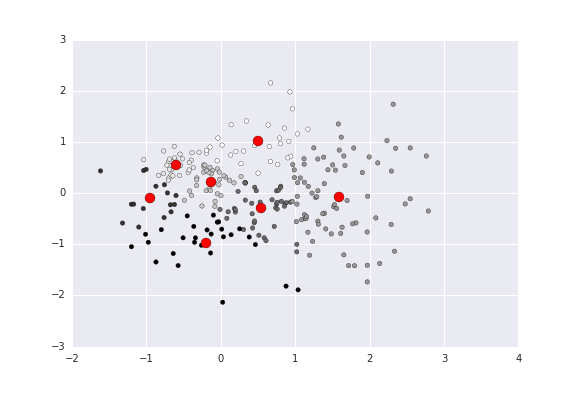
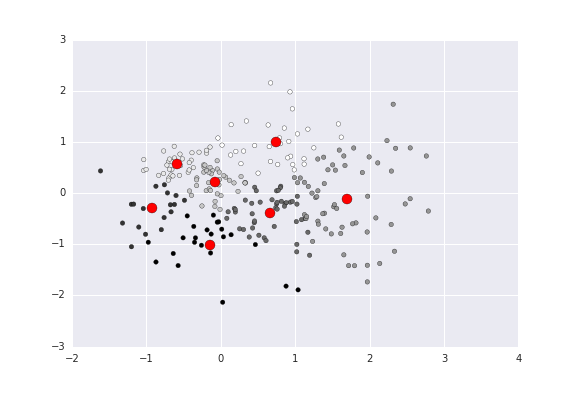
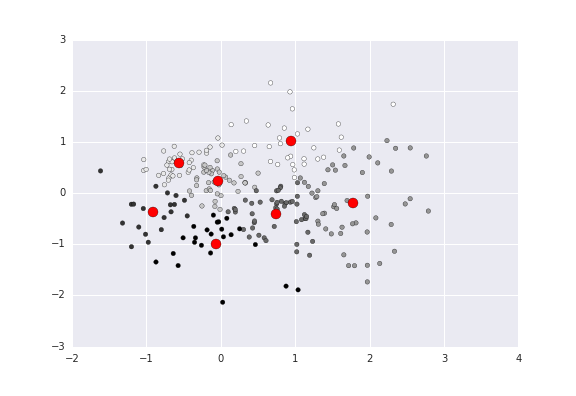
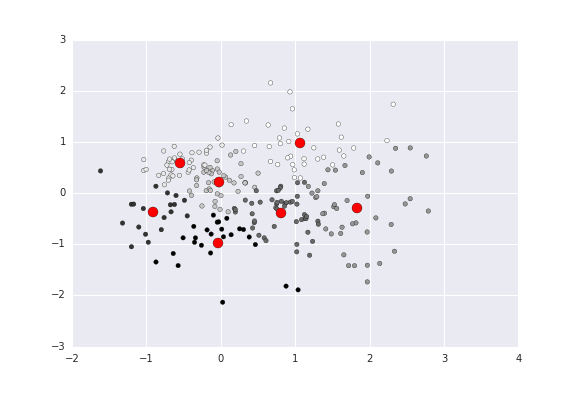
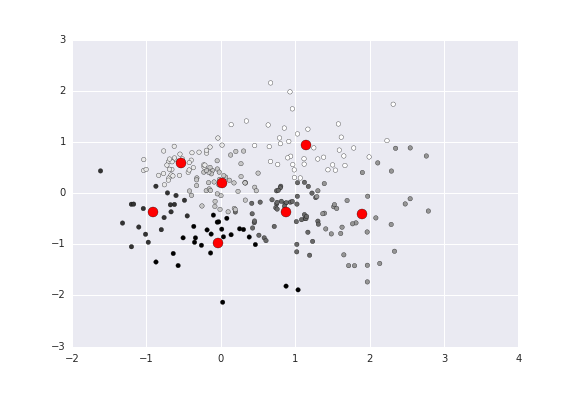
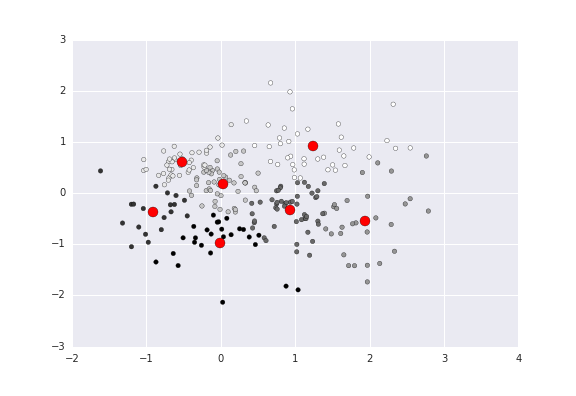
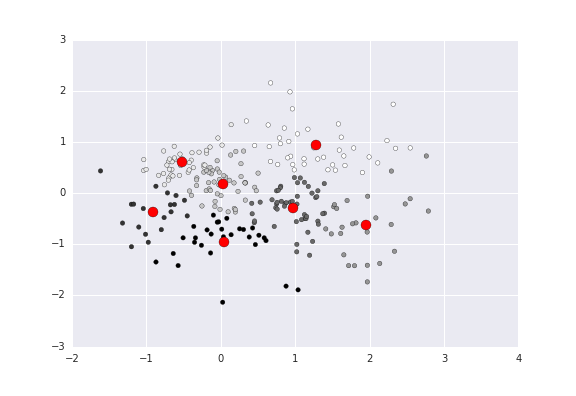
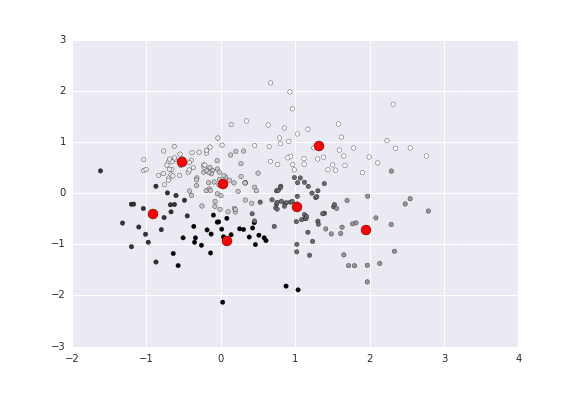
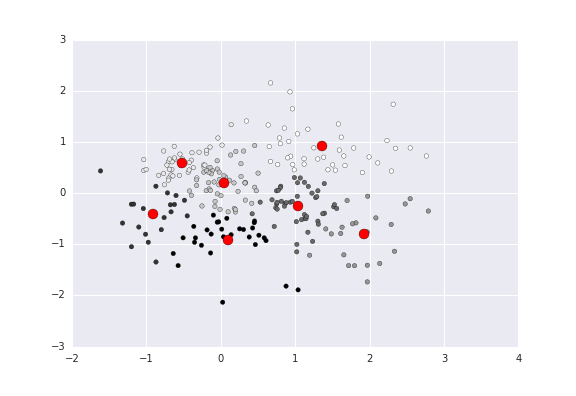
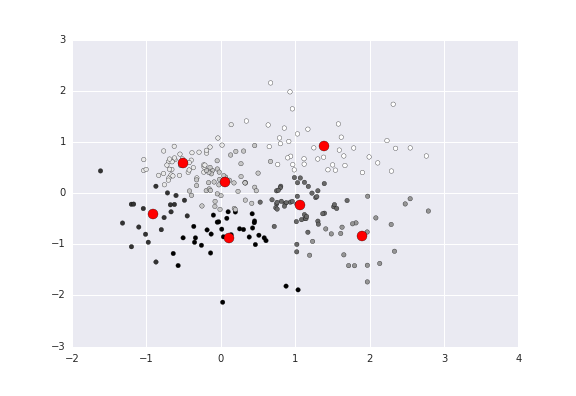
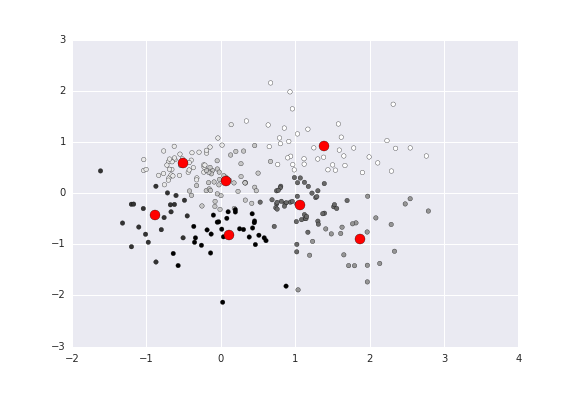
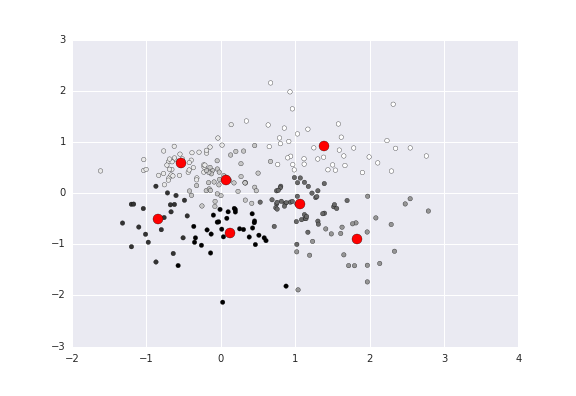
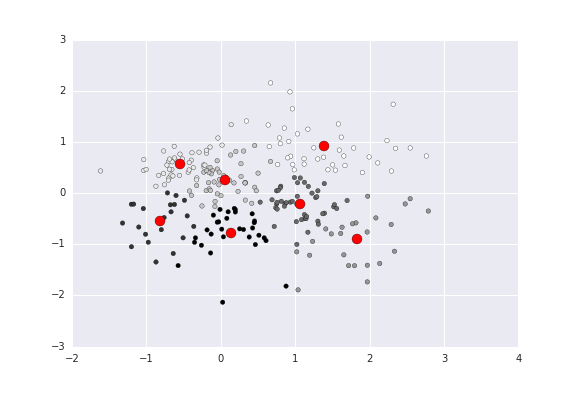
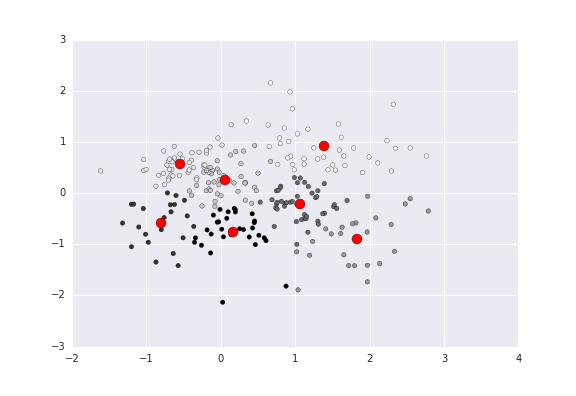
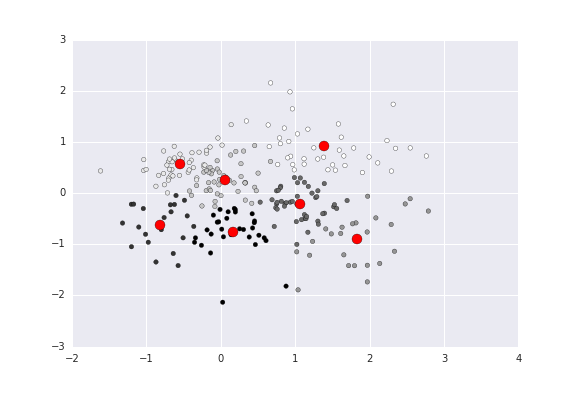
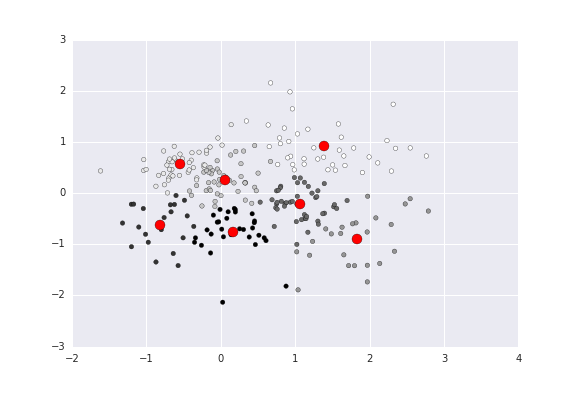
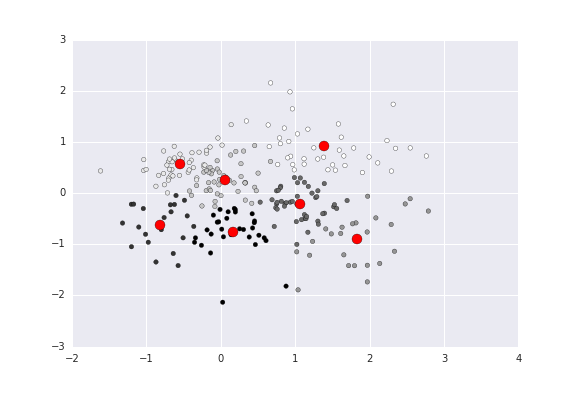
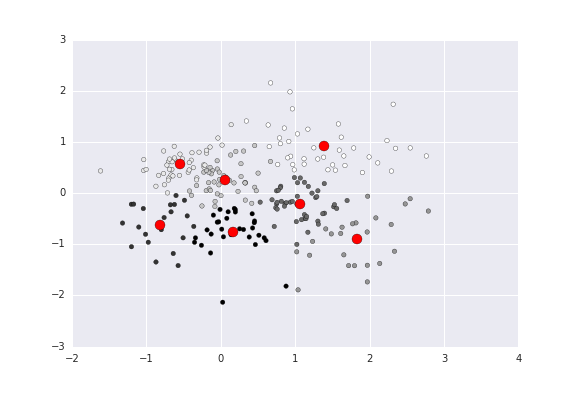
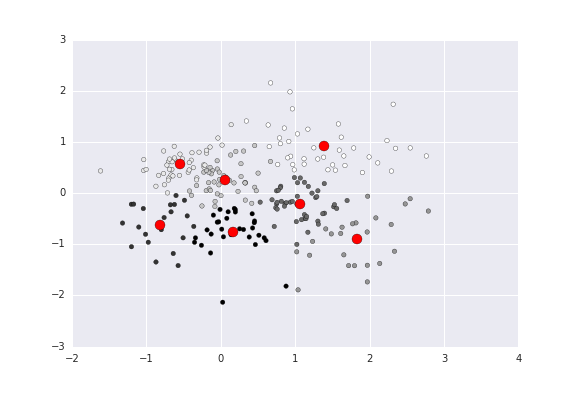
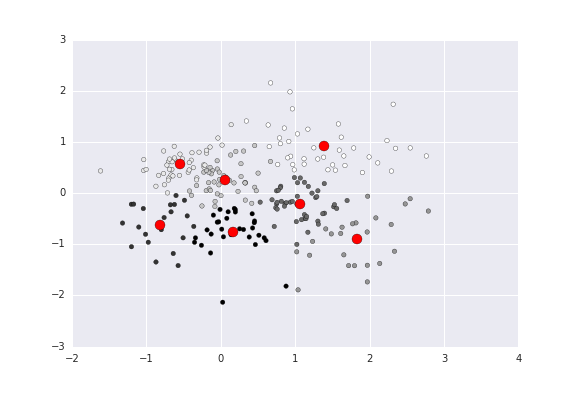
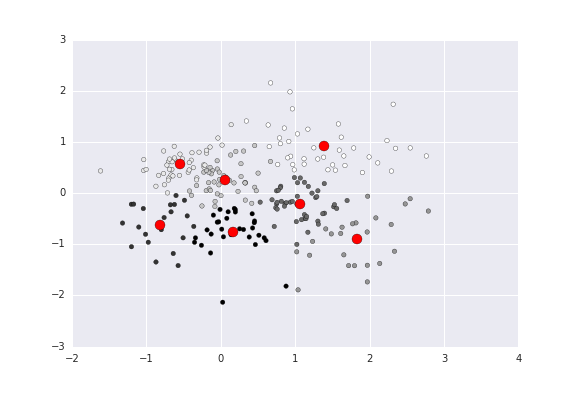
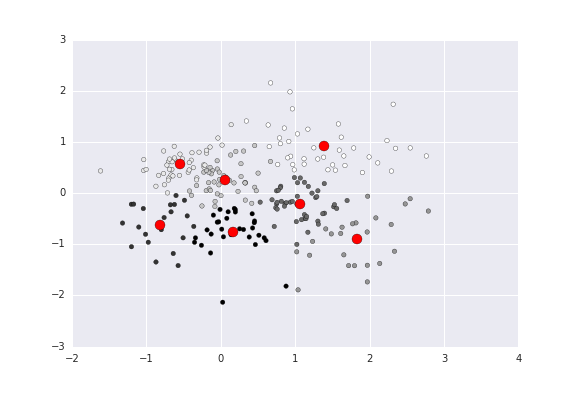
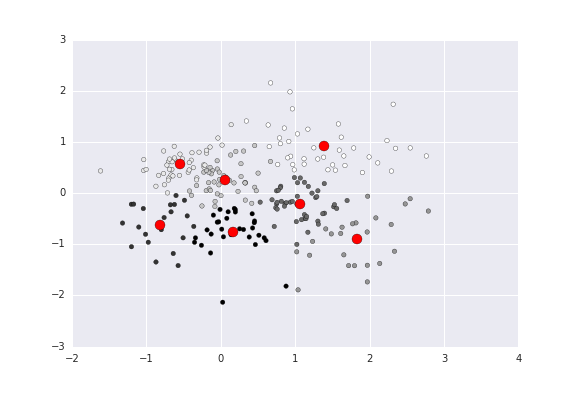
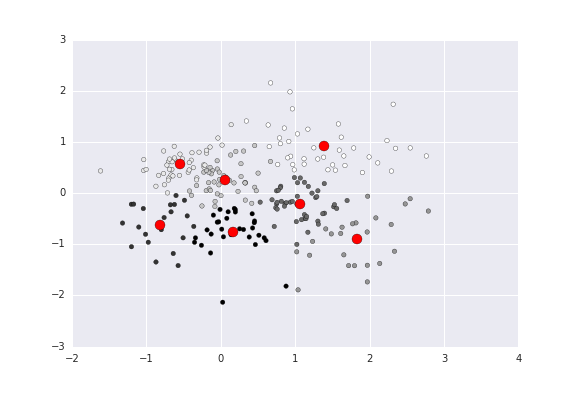
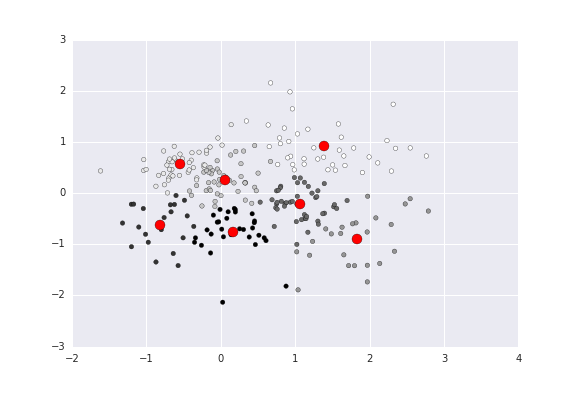
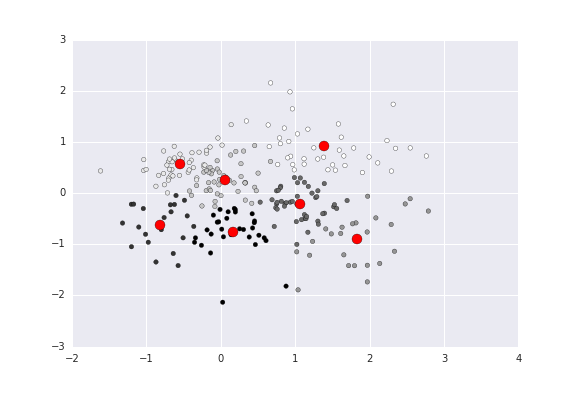
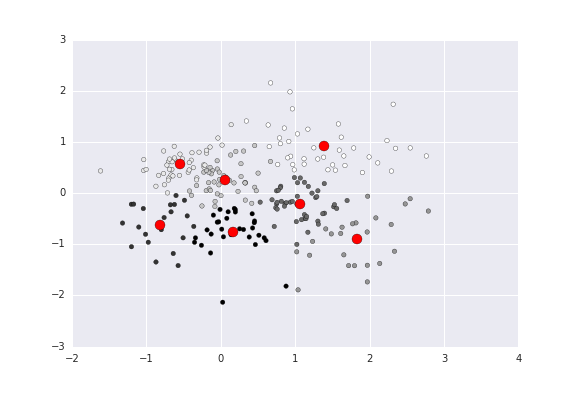
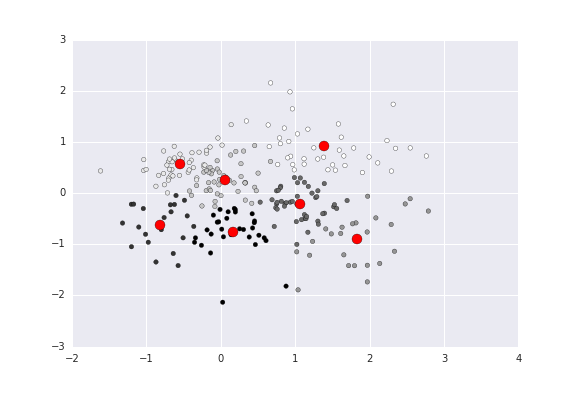
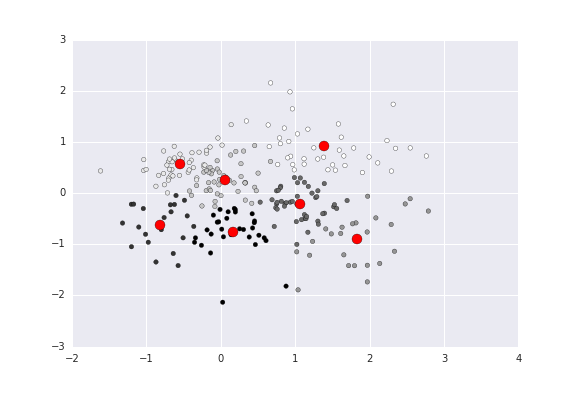

In [122]:
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-4, 4))
centroids = initialize_centroids(points, 7)

def init():
    return

def animate(i):
    global centroids
    closest = closest_centroid(points, centroids)
    centroids = move_centroids(points, closest, centroids)
    ax.cla()
    ax.scatter(points[:, 0], points[:, 1], c=closest)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)
    return 

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=30, interval=200, blit=True)

So that's it for today. I hope you have enjoyed this little notebook that demosntrated how to implement the k-means algorithm and animate it in the browser.

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20150717_Kmeans.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20150717_Kmeans.ipynb).